In [11]:
import torch
import pickle
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.nn import CrossEntropyLoss, MSELoss

from tqdm import tqdm_notebook, trange
import os
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

from multiprocessing import Pool, cpu_count
from tools import *
import convert_examples_to_features

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import pandas as pd
train_df = pd.read_csv('train.csv',header=None)
train_df.head()

,0,1
0,1,Roadwork on US 322 westbound between Oak Hall/...
1,0,#NAME?
2,1,Done-On SR 99 northbound &amp; southbound at 1...
3,0,Anybody else in Los Angeles have a fairly long...
4,0,UMMm idk where it is but its by saltyfishgirl ...


In [118]:
test_df = pd.read_csv('test.csv', header=None)
test_df.head()

,0,1
0,0,"I dont know, Arteta has said that Saka is a wi..."
1,0,Really?? looks like Keane is the one in denial...
2,1,NB &amp; SB M-13 (Sheridan Rd) between Gary Rd...
3,0,same dude
4,1,Cleared | OUTAGAMIE Co | Crash | I-41 NB | MEA...


In [4]:
# change label to (0,1)
#train_df[0] = (train_df[0] == 2).astype(int)
#test_df[0] = (test_df[0] == 2).astype(int)

In [3]:
# change data to tsv form (for BERT Input)
train_df_bert = pd.DataFrame({
    'id':range(len(train_df)),
    'label':train_df[0],
    'alpha':['a']*train_df.shape[0],
    'text': train_df[1].replace(r'\n', ' ', regex=True)
})

train_df_bert.head()

,id,label,alpha,text
0,0,1,a,Roadwork on US 322 westbound between Oak Hall/...
1,1,0,a,#NAME?
2,2,1,a,Done-On SR 99 northbound &amp; southbound at 1...
3,3,0,a,Anybody else in Los Angeles have a fairly long...
4,4,0,a,UMMm idk where it is but its by saltyfishgirl ...


In [120]:
dev_df_bert = pd.DataFrame({
    'id':range(len(test_df)),
    'label':test_df[0],
    'alpha':['a']*test_df.shape[0],
    'text': test_df[1].replace(r'\n', ' ', regex=True)
})

dev_df_bert.head()

,id,label,alpha,text
0,0,0,a,"I dont know, Arteta has said that Saka is a wi..."
1,1,0,a,Really?? looks like Keane is the one in denial...
2,2,1,a,NB &amp; SB M-13 (Sheridan Rd) between Gary Rd...
3,3,0,a,same dude
4,4,1,a,Cleared | OUTAGAMIE Co | Crash | I-41 NB | MEA...


In [121]:
# save the train and dev data as .tsv files.
train_df_bert.to_csv('train.tsv', sep='\t', index=False, header=False)
dev_df_bert.to_csv('dev.tsv', sep='\t', index=False, header=False)

In [4]:
import csv
import os
import sys
import logging

logger = logging.getLogger()
csv.field_size_limit(2147483647) # Increase CSV reader's field limit incase we have long text.

2147483647

In [5]:
class InputExample(object):

    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):

        """Constructs a InputExample.

        Args:

            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.

        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [6]:
class DataProcessor(object):

    """Base class for data converters for sequence classification data sets."""



    def get_train_examples(self, data_dir):

        """Gets a collection of `InputExample`s for the train set."""

        raise NotImplementedError()



    def get_dev_examples(self, data_dir):

        """Gets a collection of `InputExample`s for the dev set."""

        raise NotImplementedError()



    def get_labels(self):

        """Gets the list of labels for this data set."""

        raise NotImplementedError()



    @classmethod

    def _read_tsv(cls, input_file, quotechar=None):

        """Reads a tab separated value file."""

        with open(input_file, "r", encoding="utf-8") as f:

            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)

            lines = []

            for line in reader:

                if sys.version_info[0] == 2:

                    line = list(unicode(cell, 'utf-8') for cell in line)

                lines.append(line)

            return lines

In [7]:
class BinaryClassificationProcessor(DataProcessor):

    """Processor for binary classification dataset."""



    def get_train_examples(self, data_dir):

        """See base class."""

        return self._create_examples(

            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")



    def get_dev_examples(self, data_dir):

        """See base class."""

        return self._create_examples(

            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")



    def get_labels(self):

        """See base class."""

        return ["0", "1"]



    def _create_examples(self, lines, set_type):

        """Creates examples for the training and dev sets."""

        examples = []

        for (i, line) in enumerate(lines):

            guid = "%s-%s" % (set_type, i)

            text_a = line[3]

            label = line[1]

            examples.append(

                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))

        return examples

In [8]:
class InputFeatures(object):

    """A single set of features of data."""



    def __init__(self, input_ids, input_mask, segment_ids, label_id):

        self.input_ids = input_ids

        self.input_mask = input_mask

        self.segment_ids = segment_ids

        self.label_id = label_id

In [9]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):

    """Truncates a sequence pair in place to the maximum length."""



    # This is a simple heuristic which will always truncate the longer sequence

    # one token at a time. This makes more sense than truncating an equal percent

    # of tokens from each, since if one sequence is very short then each token

    # that's truncated likely contains more information than a longer sequence.

    while True:

        total_length = len(tokens_a) + len(tokens_b)

        if total_length <= max_length:

            break

        if len(tokens_a) > len(tokens_b):

            tokens_a.pop()

        else:

            tokens_b.pop()



In [10]:
def convert_example_to_feature(example_row):

    # return example_row

    example, label_map, max_seq_length, tokenizer, output_mode = example_row



    tokens_a = tokenizer.tokenize(example.text_a)



    tokens_b = None

    if example.text_b:

        tokens_b = tokenizer.tokenize(example.text_b)

        # Modifies `tokens_a` and `tokens_b` in place so that the total

        # length is less than the specified length.

        # Account for [CLS], [SEP], [SEP] with "- 3"

        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

    else:

        # Account for [CLS] and [SEP] with "- 2"

        if len(tokens_a) > max_seq_length - 2:

            tokens_a = tokens_a[:(max_seq_length - 2)]



    tokens = ["[CLS]"] + tokens_a + ["[SEP]"]

    segment_ids = [0] * len(tokens)



    if tokens_b:

        tokens += tokens_b + ["[SEP]"]

        segment_ids += [1] * (len(tokens_b) + 1)



    input_ids = tokenizer.convert_tokens_to_ids(tokens)



    # The mask has 1 for real tokens and 0 for padding tokens. Only real

    # tokens are attended to.

    input_mask = [1] * len(input_ids)



    # Zero-pad up to the sequence length.

    padding = [0] * (max_seq_length - len(input_ids))

    input_ids += padding

    input_mask += padding

    segment_ids += padding



    assert len(input_ids) == max_seq_length

    assert len(input_mask) == max_seq_length

    assert len(segment_ids) == max_seq_length



    if output_mode == "classification":

        label_id = label_map[example.label]

    elif output_mode == "regression":

        label_id = float(example.label)

    else:

        raise KeyError(output_mode)



    return InputFeatures(input_ids=input_ids,

                         input_mask=input_mask,

                         segment_ids=segment_ids,

                         label_id=label_id)

In [10]:
# The input data dir. Should contain the .tsv files (or other data files) for the task.
DATA_DIR = "/home/xwan6/Bert_classify/"

# Bert pre-trained model selected in the list: bert-base-uncased, 
# bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased,
# bert-base-multilingual-cased, bert-base-chinese.
BERT_MODEL = 'bert-base-cased'

# The name of the task to train.I'm going to name this 'yelp'.
TASK_NAME = 'yelp'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = f'outputs/{TASK_NAME}/'

# The directory where the evaluation reports will be written to.
REPORTS_DIR = f'reports/{TASK_NAME}_evaluation_report/'

# This is where BERT will look for pre-trained models to load parameters from.
CACHE_DIR = 'cache/'

# The maximum total input sequence length after WordPiece tokenization.
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.
MAX_SEQ_LENGTH = 128

TRAIN_BATCH_SIZE = 24
EVAL_BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1
OUTPUT_MODE = 'classification'

CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"

In [11]:
output_mode = OUTPUT_MODE
cache_dir = CACHE_DIR

In [ ]:
if os.path.exists(REPORTS_DIR) and os.listdir(REPORTS_DIR):
        REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
        os.makedirs(REPORTS_DIR)
if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)

In [ ]:
if os.path.exists(OUTPUT_DIR) and os.listdir(OUTPUT_DIR):
        raise ValueError("Output directory ({}) already exists and is not empty.".format(OUTPUT_DIR))
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [12]:
processor = BinaryClassificationProcessor()
train_examples = processor.get_train_examples(DATA_DIR)
train_examples_len = len(train_examples)

In [13]:
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)

In [14]:
num_train_optimization_steps = int(
    train_examples_len / TRAIN_BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS) * NUM_TRAIN_EPOCHS

In [15]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /home/xwan6/.pytorch_pretrained_bert/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1


In [16]:
label_map = {label: i for i, label in enumerate(label_list)}
train_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE) for example in train_examples]

In [136]:
# process the examples with multiple cpu (slightly fast)
process_count = cpu_count() - 1
if __name__ ==  '__main__':
    print(f'Preparing to convert {train_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        train_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, train_examples_for_processing), total=train_examples_len))

Preparing to convert 96518 examples..
Spawning 31 processes..


In [137]:
# save pickle
#with open(DATA_DIR + "train_features.pkl", "wb") as f:
    #pickle.dump(train_features, f)

In [17]:
# open pickle
with open(DATA_DIR + "train_features.pkl", "rb") as f:
    train_features = pickle.load(f)

In [18]:
# Load pre-trained model (weights)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, cache_dir=CACHE_DIR, num_labels=num_labels)
# model = BertForSequenceClassification.from_pretrained(CACHE_DIR + 'cased_base_bert_pytorch.tar.gz', cache_dir=CACHE_DIR, num_labels=num_labels)

INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz from cache at cache/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c
INFO:pytorch_pretrained_bert.modeling:extracting archive file cache/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c to temp dir /tmp/tmprum3pxkd
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_pretrained_bert.modeling:Weights of BertForSequenceClassification not initialized from pretrained model: ['clas

In [19]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [20]:
# use the default parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

In [21]:
optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=LEARNING_RATE,
                     warmup=WARMUP_PROPORTION,
                     t_total=num_train_optimization_steps)

In [22]:
global_step = 0
nb_tr_steps = 0
tr_loss = 0

In [23]:
logger.info("***** Running training *****")
logger.info("  Num examples = %d", train_examples_len)
logger.info("  Batch size = %d", TRAIN_BATCH_SIZE)
logger.info("  Num steps = %d", num_train_optimization_steps)
all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)

if OUTPUT_MODE == "classification":
    all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
elif OUTPUT_MODE == "regression":
    all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.float)

INFO:root:***** Running training *****
INFO:root:  Num examples = 96518
INFO:root:  Batch size = 24
INFO:root:  Num steps = 4021


In [24]:
# Setting up our DataLoader for training..
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=TRAIN_BATCH_SIZE)

In [25]:
# training time
model.train()
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    loss_record = []
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm_notebook(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        logits = model(input_ids, segment_ids, input_mask, labels=None)

        if OUTPUT_MODE == "classification":
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif OUTPUT_MODE == "regression":
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), label_ids.view(-1))

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        print("\r%f" % loss, end='')
        # get the loss for each steps
        loss_record.append(loss.item())
        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

0.000086

Epoch: 100%|██████████| 1/1 [16:30<00:00, 990.91s/it]

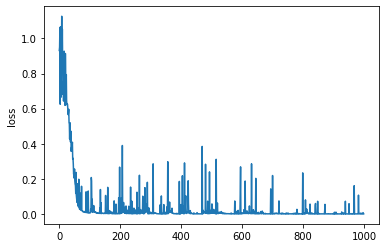

In [29]:
import matplotlib.pyplot as plt
plt.plot(loss_record[:1000])
plt.ylabel('loss')
plt.show()

In [47]:
# save the model
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
model_to_save.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
# If we save using the predefined names, we can load using `from_pretrained`
#output_model_file = os.path.join(OUTPUT_DIR, WEIGHTS_NAME)
#output_config_file = os.path.join(OUTPUT_DIR, CONFIG_NAME)

#torch.save(model_to_save.state_dict(), output_model_file)
#model_to_save.config.to_json_file(output_config_file)
#tokenizer.save_vocabulary(OUTPUT_DIR)

# load the model
#model_type = 'bert'
#MODEL_CLASSES = {
#    'bert': (BertConfig, BertForQuestionAnswering, BertTokenizer),
#    'xlnet': (XLNetConfig, XLNetForQuestionAnswering, XLNetTokenizer),
#    'xlm': (XLMConfig, XLMForQuestionAnswering, XLMTokenizer),
#    'distilbert': (DistilBertConfig, DistilBertForQuestionAnswering, DistilBertTokenizer)
#}
#config_class, model_class, tokenizer_class = MODEL_CLASSES['bert']
#config = config_class.from_pretrained(BERT_MODEL)
#model = model_class.from_pretrained(Output_dir)
#tokenizer = tokenizer_class.from_pretrained(Output_dir, do_lower_case=True)
#model.to(device)

'outputs/yelp/vocab.txt'

In [30]:
# Evaluation
import torch
import numpy as np
import pickle

from sklearn.metrics import matthews_corrcoef, confusion_matrix

from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from torch.nn import CrossEntropyLoss, MSELoss

from tools import *
from multiprocessing import Pool, cpu_count
import convert_examples_to_features

from tqdm import tqdm_notebook, trange
import os
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam, WarmupLinearSchedule

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [31]:
# The input data dir. Should contain the .tsv files (or other data files) for the task.
DATA_DIR = "/home/xwan6/Bert_classify/"

# Bert pre-trained model selected in the list: bert-base-uncased, 
# bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased,
# bert-base-multilingual-cased, bert-base-chinese.
#BERT_MODEL = 'bert-base-cased'

# The name of the task to train.I'm going to name this 'yelp'.
TASK_NAME = 'yelp'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = '/home/xwan6/Bert_classify/outputs/yelp/'

# The directory where the evaluation reports will be written to.
REPORTS_DIR = '/home/xwan6/Bert_classify/reports/yelp_evaluation_reports/'

# This is where BERT will look for pre-trained models to load parameters from.
CACHE_DIR = 'cache/'

# The maximum total input sequence length after WordPiece tokenization.
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.
MAX_SEQ_LENGTH = 128

TRAIN_BATCH_SIZE = 24
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1
RANDOM_SEED = 42
GRADIENT_ACCUMULATION_STEPS = 1
WARMUP_PROPORTION = 0.1
OUTPUT_MODE = 'classification'

CONFIG_NAME = "config.json"
WEIGHTS_NAME = "pytorch_model.bin"

In [149]:
if os.path.exists(REPORTS_DIR) and os.listdir(REPORTS_DIR):
        REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
        os.makedirs(REPORTS_DIR)
if not os.path.exists(REPORTS_DIR):
    os.makedirs(REPORTS_DIR)
    REPORTS_DIR += f'/report_{len(os.listdir(REPORTS_DIR))}'
    os.makedirs(REPORTS_DIR)

In [32]:
def get_eval_report(task_name, labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "task": task_name,
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }

def compute_metrics(task_name, labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(task_name, labels, preds)

In [33]:
# Note that we must remove wrap cell in the csv in order to process
processor = BinaryClassificationProcessor()
eval_examples = processor.get_dev_examples(DATA_DIR)
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)
eval_examples_len = len(eval_examples)

In [34]:
label_map = {label: i for i, label in enumerate(label_list)}
eval_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE) for example in eval_examples]

In [35]:
process_count = cpu_count() - 1
if __name__ ==  '__main__':
    print(f'Preparing to convert {eval_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        eval_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, eval_examples_for_processing), total=eval_examples_len))

Preparing to convert 10000 examples..
Spawning 31 processes..


In [36]:
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)

In [37]:
if OUTPUT_MODE == "classification":
    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
elif OUTPUT_MODE == "regression":
    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.float)

In [38]:
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=EVAL_BATCH_SIZE)

In [39]:
# Load pre-trained model (weights)
#model = BertForSequenceClassification.from_pretrained(CACHE_DIR + BERT_MODEL, cache_dir=CACHE_DIR, num_labels=len(label_list))

In [40]:
model.eval()
eval_loss = 0
nb_eval_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        logits = model(input_ids, segment_ids, input_mask, labels=None)

    # create eval loss and other metric required by the task
    if OUTPUT_MODE == "classification":
        loss_fct = CrossEntropyLoss()
        tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
    elif OUTPUT_MODE == "regression":
        loss_fct = MSELoss()
        tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

    eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

eval_loss = eval_loss / nb_eval_steps
preds = preds[0]
if OUTPUT_MODE == "classification":
    preds = np.argmax(preds, axis=1)
elif OUTPUT_MODE == "regression":
    preds = np.squeeze(preds)
result = compute_metrics(TASK_NAME, all_label_ids.numpy(), preds)

result['eval_loss'] = eval_loss

output_eval_file = os.path.join(REPORTS_DIR, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results *****")
    for key in (result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

INFO:root:***** Eval results *****
INFO:root:  task = yelp
INFO:root:  mcc = 0.9989981785404111
INFO:root:  tp = 4774
INFO:root:  tn = 5221
INFO:root:  fp = 1
INFO:root:  fn = 4
INFO:root:  eval_loss = 0.0025233404874801637


In [199]:
# now we use our model to extract related information
import pandas as pd
test_df = pd.read_csv('example.csv')
# change data to tsv form (for BERT Input)
test_df_bert = pd.DataFrame({
    'id':range(len(test_df)),
    'label':[0]*test_df.shape[0],
    'alpha':['a']*test_df.shape[0],
    'text': test_df['text'].replace(r'\n', ' ', regex=True)
})
test_df_bert.head()

,id,label,alpha,text
0,0,0,a,Inside HT's policy briefing: Lobbying Act revi...
1,1,0,a,Oh boy oh boy oh boy I wonder who the next spr...
2,2,0,a,Games just issuing delay statements daily now
3,3,0,a,Did they actually just cite a problem near the...
4,4,0,a,"We're sorry there was a delay in our response,..."


In [200]:
# save the test data as .tsv files.
test_df_bert.to_csv('dev.tsv', sep='\t', index=False, header=False)
processor = BinaryClassificationProcessor()
eval_examples = processor.get_dev_examples(DATA_DIR)
label_list = processor.get_labels() # [0, 1] for binary classification
num_labels = len(label_list)
eval_examples_len = len(eval_examples)

In [201]:
label_map = {label: i for i, label in enumerate(label_list)}
eval_examples_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE) for example in eval_examples]

process_count = cpu_count() - 1
if __name__ ==  '__main__':
    print(f'Preparing to convert {eval_examples_len} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        eval_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, eval_examples_for_processing), total=eval_examples_len))
        

Preparing to convert 10000 examples..
Spawning 31 processes..


In [202]:
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)

if OUTPUT_MODE == "classification":
    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
elif OUTPUT_MODE == "regression":
    all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.float)

In [203]:
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=EVAL_BATCH_SIZE)

In [204]:
model.eval()
eval_loss = 0
nb_eval_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        logits = model(input_ids, segment_ids, input_mask, labels=None)

    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

preds = preds[0]
if OUTPUT_MODE == "classification":
    preds = np.argmax(preds, axis=1)
elif OUTPUT_MODE == "regression":
    preds = np.squeeze(preds)

In [209]:
result = pd.DataFrame(preds)
result = result.to_csv('result.csv')

In [74]:
# test for one sentence
#text = 'I will visit the transportation office tomorrow at Garden parkay but my car is crashed.'
text = 'An accident on 73 SB approaching Fellowship Rd is causing a delay between 295 and the NJ Turnpike.'

In [75]:
eval_ex = []
for i in range(10):
    eval_ex.append(InputExample('1',text,None,'0'))

In [76]:
eval_ex_for_processing = [(example, label_map, MAX_SEQ_LENGTH, tokenizer, OUTPUT_MODE) for example in eval_ex]

In [77]:
label_map = {label: i for i, label in enumerate(label_list)}
process_count = cpu_count() - 1
if __name__ ==  '__main__':
    print(f'Preparing to convert {1} examples..')
    print(f'Spawning {process_count} processes..')
    with Pool(process_count) as p:
        eval_features = list(tqdm_notebook(p.imap(convert_examples_to_features.convert_example_to_feature, eval_ex_for_processing), total=1))

Preparing to convert 1 examples..
Spawning 31 processes..


In [78]:
all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)

In [79]:
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=EVAL_BATCH_SIZE)

In [80]:
model.eval()
eval_loss = 0
nb_eval_steps = 0
preds = []

for input_ids, input_mask, segment_ids, label_ids in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)

    with torch.no_grad():
        logits = model(input_ids, segment_ids, input_mask, labels=None)
    if len(preds) == 0:
        preds.append(logits.detach().cpu().numpy())
    else:
        preds[0] = np.append(
            preds[0], logits.detach().cpu().numpy(), axis=0)

preds = preds[0]
preds = np.argmax(preds, axis=1)

In [81]:
preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])